## Imports

In [1]:
import os
import math

import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
sns.set()

In [2]:
import mixtureofconcave as subm
import determinantal as logsubm
import plottingtools

## Plottingtools

In [3]:
#%% Plot gain curves

def objplot(objs, ground, setcolor, setcolorground=None):
    krange = np.arange(len(objs))
    
    plt.plot(krange, objs, "o", c=setcolor, label="f(S)")
    if setcolorground is not None:
        plt.plot(krange, [ground,]*len(objs), "--", c=setcolorground, label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=2)

def logobjplot(objs, ground, setcolor, setcolorground=None):
    krange = np.arange(len(objs))
    
    plt.plot(krange, np.log(objs), "o", c=setcolor, label="log(f(S))")
    if setcolorground is not None:
        plt.plot(krange, [np.log(ground),]*len(objs), "--", c=setcolorground, label="ground set eval")
    plt.xlabel("set size")
    plt.legend(loc=2)


In [4]:
#%% Plot TSNE of subset selection

def viztsne(X, vcolor, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    plt.scatter(Xemb[:,0], Xemb[:,1], c=vcolor)
    plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
    plt.legend()

#%% Plot TSNE of subset selection -- with Discrete Memberships

def viztsne_DMQ(X, Memvec, memcolors, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    for jj in range(p):
        memgrp = np.argwhere(Memvec[:,jj])
        plt.scatter(Xemb[memgrp,0], Xemb[memgrp,1], c=memcolors[jj])
    plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
    plt.legend()

#%% Plot TSNE of subset selection -- with Intersecting Memberships

def viztsne_IMQ(X, Memvec, memcolors, S, setcolor, setlabel, perp):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d TSNE
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    Xemb = TSNE(n_components=2, random_state=256).fit_transform(X)
    
    plt.figure(figsize=(p*5, 5))
    for jj in range(p):
        plt.subplot(1,p,jj+1)
        plt.scatter(Xemb[:,0], Xemb[:,1], c=memcolors[0])
        
        memgrp = np.argwhere(Memvec[:,jj])
        plt.scatter(Xemb[memgrp,0], Xemb[memgrp,1], c=memcolors[1], label="group{}".format(jj+1))
        
        plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
        plt.legend()


In [5]:
#%% Plot PCA reduction of subset selection

def vizpca(X, vcolor, S, setcolor, setlabel="selection"):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d PCA
    """
    
    [n,m] = X.shape
    
    Xemb = PCA(n_components=m).fit(X).transform(X)[:,:2]
    
    plt.scatter(Xemb[:,0], Xemb[:,1], c=vcolor)
    plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
    plt.legend()

#%% Plot PCA reduction of subset selection -- with Discrete Memberships

def vizpca_DMQ(X, Memvec, memcolors, S, setcolor, setlabel="selection"):
    """ Given an nxm feature matrix X
        A selection of indices S of size k < n
        An n x p Membership matrix for p groups
        Plot the selection's 2d PCA
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    Xemb = PCA(n_components=m).fit(X).transform(X)[:,:2]
    
    for jj in range(p):
        memgrp = np.argwhere(Memvec[:,jj])
        plt.scatter(Xemb[memgrp,0], Xemb[memgrp,1], c=memcolors[jj])
    plt.scatter(Xemb[S,0], Xemb[S,1], facecolors="none", edgecolors=setcolor, linewidth=2, label=setlabel)
    plt.legend()


In [6]:
#%% Plot TSNE of subset selection -- with Feature Quotas

#


In [7]:
#%% Plot Group Membership histograms of selections -- Membership Quota

def vizbalance_MQ(V, Memvec, vcolor, quo, S, setcolor, setlabel="selection"):
    """ Given a ground set (n)
        With Membership Assignments (n x p)
        And optionally a quota
        A selection of indices S of size k < n
        Plot the selection's 2d PCA
    """
    
    [n,p] = Memvec.shape
    if V is None:
        V = np.arange(n)
    
    Vgroups = np.zeros(p)
    Sgroups = np.zeros(p)
    unsat = np.empty((0)).astype(int)
    
    for jj in range(p):
        Vgroups[jj] = np.sum(Memvec[V,jj])
        Sgroups[jj] = np.sum(Memvec[S,jj])
        if Sgroups[jj] < quo[jj]:
            unsat = np.append(unsat, jj)
    
    print(unsat)
    plt.bar(np.arange(p), Vgroups, color=vcolor)
    plt.bar(np.arange(p), Sgroups, color=setcolor, label=setlabel)
    plt.plot(np.arange(p), quo, marker="o", linestyle="--", c="white", markersize=7)
    plt.scatter(unsat, quo[unsat], c="red", s=7, zorder=10)
    plt.legend()


---

## Log-submodular

### DPP

In [8]:
#%% Marginal gain oracle of the utility

def dppgains(K, AA, aa, detKA):
    """ Returns det(K_{A+a}) - det(K_A)
        BEING EXTREMELY CRUDE HERE,
        A more efficient way might be possible
    """
    
    Aa = np.append(AA,aa)
    KAa = np.atleast_2d(K[Aa])[:,Aa]
    
    return np.linalg.det(KAa) - detKA


In [9]:
#%% Plain old simple Greedy

def greedygains_logsubmod(V, X, k):
    """ For a given ground set, a feature matrix whose determinant defines the objective
        (THIS IS FOR A DPP),
        Returns the greedy selection and step-wise objective values
        Over the addition of k items
    """
    
    K = X @ X.transpose()
    n = K.shape[0]
    
    if V is None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    ff = 1 # since this is a determinantal process and det(\phi) = 1
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = dppgains(K, A, V[vidx], ff)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs


### Run

In [10]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))

K = X @ X.transpose()
ground = np.linalg.det(K)

In [11]:
S, objectives = greedygains_logsubmod(None, X, k)

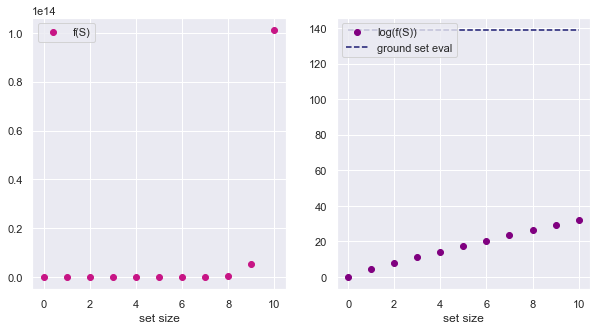

In [12]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
objplot(objectives, ground, "mediumvioletred")
plt.subplot(1,2,2)
logobjplot(objectives, ground, "purple", "midnightblue")

In [13]:
for oo in objectives: print("{:.3f}".format(oo))

1.000
74.940
2486.709
63555.810
1487750.070
31893574.032
677766067.108
14108951137.618
276220495859.501
5396136349373.081
101255403669399.172


---

## Submodular

### A weighted mixture of m(A)^{0.2}

In [14]:
#%% Marginal gain oracle of the utility

def submodgains(X, modA, fA, aa, mixw):
    """ Returns f(A+a) - f(A)
        Where f(A) = \sum_{j=1}^m (w_j * \phi(\sum_{i \in A} X_{ij}))
    """
    
    modAa = modA + X[aa,:] if aa is not None else modA
    
    # options: modA**0.5, np.log(1+modA), (1-np.exp(-modA)), modA/(1+modA)
    fAa = np.dot(mixw, modAa**0.2)
    
    return fAa - fA


In [15]:
#%% Plain old simple Greedy

def greedygains_submod(V, X, mixw, k):
    """ For a given ground set, a feature matrix and mixture weights which define the objective
        (submodular),
        Returns the greedy selection and step-wise objective values
        Over the addition of k items
    """
    
    [n,m] = X.shape
    
    if V is None:
        V = np.arange(n)
    
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    for ii in range(k):
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
    
    return A, objs


In [16]:
#%% Greedy for DMQ

def greedyDMquota_submod(V, X, mixw, Memvec, quo, k, verbose=False):
    """ For the disjoint membership quota.
        Memvec is an n x p one-hot matrix (exactly one 1 per row).
        quo is a p x 1 vector.
        Output a subset that satisfies the quotas.
    """
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    if V is None:
        V = np.arange(n)
    
    for grp in range(p):
        if np.sum(Memvec[:,grp]) < quo[grp]:
            print("Not enough members in group {}, infeasible problem.".format(grp))
            return None, None
        
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    """ Quota-filling stage """
    
    ii = 0
    Vsat = np.copy(V) # only for use in the quota-filling stage
    
    # remove from Vsat groups with zero quota
    for grp in range(p):
        if quo[grp] < 1:
            Vsat = np.delete(Vsat, np.argwhere(Memvec[Vsat,grp].flatten()))
    
    while ii < np.sum(quo):
        
        maxgain = -100
        greedyv = np.random.choice(Vsat)
        
        for vidx in range(len(Vsat)):
            gain = submodgains(X, modA, ff, Vsat[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = Vsat[vidx]
        
        # add element to A, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        ff += maxgain
        objs[ii+1] = ff
        
        # remove from V, remove all from Vsat if quota filled
        V = V[V!=greedyv]
        grp = np.argwhere(Memvec[greedyv])

        if verbose:
            print("selected element", greedyv)
            print("lies in group", grp)
            #print("new A", A)

        if np.sum(Memvec[A,grp]) >= quo[grp]:
            if verbose:
                print("\n Quota for group {} satisfied by set {} \n".format(
                        grp, A[Memvec[A,grp].flatten().astype(bool)])
                     )
                print("Deleting {}".format(Vsat[Memvec[Vsat,grp].flatten().astype(bool)]))
            Vsat = np.delete(Vsat, np.argwhere(Memvec[Vsat,grp].flatten()))
        else:
            if verbose:
                print("Only deleting", Vsat[Vsat==greedyv])
            Vsat = Vsat[Vsat!=greedyv]
        
        ii += 1
        
    if verbose:
        print("Quotas filled.")
        print("quotas : ", quo)
        print("Representatives : ", [np.sum(Memvec[A,jj]) for jj in range(p)])
    
    
    """ Regular greedy stage """
    
    while ii < k:
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
        
        if verbose:
            print("selected element", greedyv)
            print("lies in group", np.argwhere(Memvec[greedyv]))
            #print("new A", A)
        
        ii += 1
    
    return A, objs


### Run

In [17]:
n = 50
m = 200
k = 10

np.random.seed(0)
X = np.random.random((n, m))
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

ground = np.dot(mixw, np.sum(X, axis=0)**0.2)

In [18]:
S, objectives = greedygains_submod(None, X, mixw, k)

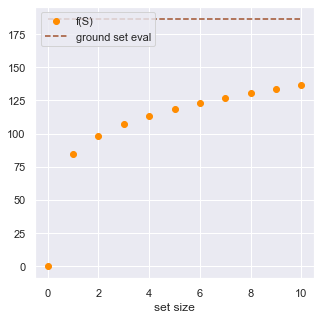

In [19]:
plt.figure(figsize=(5,5))
objplot(objectives, ground, "darkorange", "sienna")

In [20]:
for oo in objectives: print("{:.3f}".format(oo))

0.000
84.346
98.494
107.093
113.569
118.826
123.244
127.106
130.542
133.648
136.481


---

## DPP v/s Submodular

In [21]:
n = 500
m = 72
k = 25

np.random.seed(0)
X = np.random.random((n, m))

np.random.seed(1)
mixw = np.random.random(m); mixw = mixw/np.max(mixw)

In [22]:
S_d, objectives_d = greedygains_logsubmod(None, X, k)

In [23]:
S_s, objectives_s = greedygains_submod(None, X, mixw, k)

/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'a

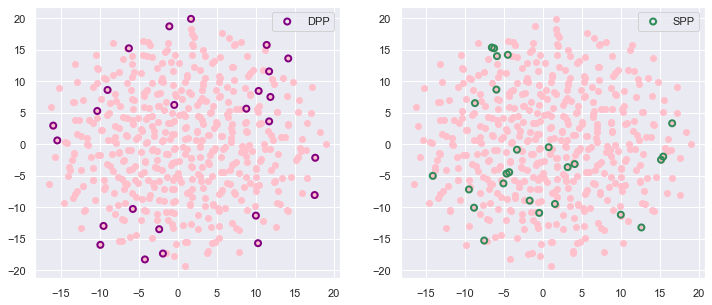

In [25]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
viztsne(X, "pink", S_d, "purple", "DPP", 30)
plt.subplot(1,2,2)
viztsne(X, "pink", S_s, "seagreen", "SPP", 30)

---

## Aadhi Quotoba mag Vithoba

Compare:<br>
Feasibility, output quality, computational complexity.

---

<p style="background-color:#ff9933">
Constrained Submodular Max with Disjoint Membership Quota
</p>

Things to look out for:<br>
1. More number of groups <--> more constraint on maximizing w.r.t. one group
2. Having the groups correlating with features <--> making some group sinherently _better_ <--> making the quotas output worser solutions maybe.
3. Try with the _learnt_ ILMSF weights.. that way you have a "true" submodular mixture utility. You could also use true labels!!
4. Alternatively, "assign" groups via clustering.

In [26]:
n_samples = 1000
m_features = 2
k_budget = 100

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [27]:
p_groups = 20
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

In [28]:
#%% Random group assignment

np.random.seed(2)
Memvec = np.eye(p_groups)[np.random.choice(p_groups, n_samples)].astype(int)

#print([len(np.argwhere(Memvec[:,jj])) for jj in range(p_groups)])
print(np.sum(Memvec, axis=0))

#%%Clustering-based group assignment

# kmeans = KMeans(n_clusters=p_groups, random_state=0).fit(X)
# Memvec = np.eye(p_groups)[kmeans.labels_].astype(int)

#%% Viz

# vizpca_DMQ(X, Memvec, memcolors, [], "orange", "Group assignment")

[49 48 49 34 39 52 49 46 59 54 59 56 50 37 47 48 53 54 59 58]


In [29]:
#%% Uniform quota

quo = np.ones(p_groups)*3

#%% Proportionate quota

# quo = np.sum(Memvec, axis=0)*k_budget//n_samples - 3

Objective without quota 3.855625803676566 
 [210 610 632 149 906 516 397 779 702 658 730 878 224 430 775 223 312 382
 284 135 659 281 978 713 726 320 452  82 822 188 577  74 594 317 912 860
 791 584 479  51 192 595 363 601  10 920 238 552 360 837 384 562 762 671
 138 742 559 662 490 493 590 698 269 909 768 872 652 295 546   9 629 511
 812 829 391 150 237 229 432 790 512 850 404 389 970 114 654 174 568 699
  81 587 990 946 814 259 835 439 897 425]
Objective with quota 3.8552007268979565 
 [210 610 632 149 906 516 397 779 702 658 730 878 224 430 775 223 312 382
 284 135 659 281 978 713 726 320 452  82 822 188  74 594 912 791 584  51
 479 192 595 363  10 920 384 762 138 742 559 493 872 295   9 511 812 829
 850 970 568  81 990 402 577 317 860 601 238 360 552 837 562 671 662 490
 590 698 269 909 768 652 546 629 391 150 432 229 237 790 512 404 389 114
 654 174 699 587 814 946 259 835 439 897]
Objective of random selection 3.463324298701191 
 [981  13 576 700 576 679 109 512 624 449  87 282 9

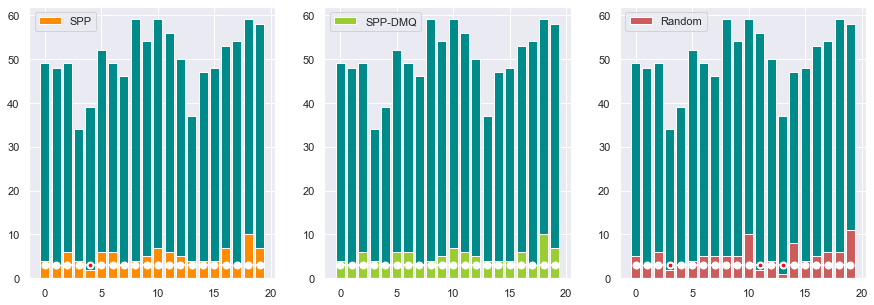

In [30]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k_budget)
S_sq, objectives_sq = subm.greedyDMquota_submod(None, X, mixw, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_r,:], axis=0), 0, None, mixw)

print("Objective without quota", objectives_s[-1], "\n", S_s)
print("Objective with quota", objectives_sq[-1], "\n", S_sq)
print("Objective of random selection", objective_sr, "\n", S_r)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_s, "darkorange", "SPP")
plt.subplot(1,3,2)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_sq, "yellowgreen", "SPP-DMQ")
plt.subplot(1,3,3)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_r, "indianred", "Random")

In [ ]:
# S_sq, objectives_sq = greedyDMquota_submod(None, X, mixw, Memvec, quo, k_budget, True)

= = = = 

Can we show that there is some benefit to adding _good_ elements _after_ we have met
fairness (here, diversity?! if they are geometrically correlated...) constraints.

We don't want to confuse _good_ with _diverse_. I mean we do want to pick the good ones among the diverse tho...<br>
Is it like -- the group that is picked last gets more quality canditades chosen? and the one that goes first gets filled with token shit??

= = = = 

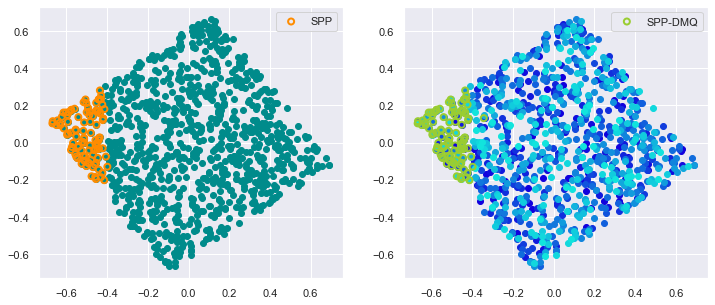

In [31]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
vizpca(X, "darkcyan", S_s, "darkorange", "SPP")
plt.subplot(1,2,2)
vizpca_DMQ(X, Memvec, memcolors, S_sq, "yellowgreen", "SPP-DMQ")

/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/neerajaabhyankar/Library/Caches/pypoetry/virtualenvs/ml-playground-U3_zo12P-py3.8/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


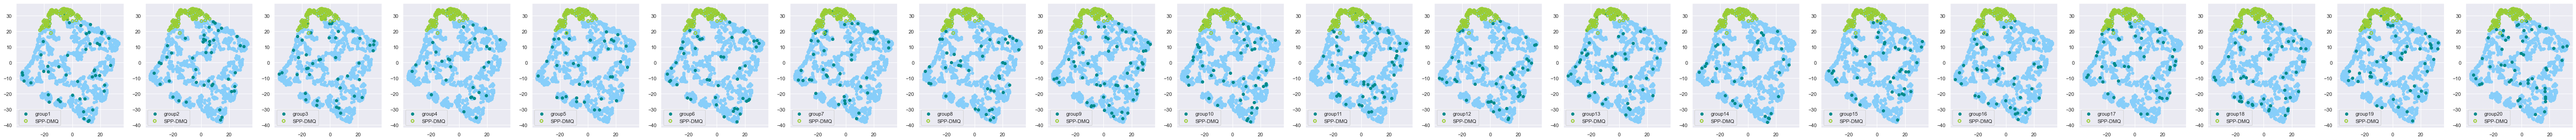

In [32]:
viztsne_IMQ(X, Memvec, ["lightskyblue", "darkcyan"], S_sq, "yellowgreen", "SPP-DMQ", 30)

---

<p style="background-color:#ff99cc">
Constrained Submodular Max with Intersecting Membership Quota
</p>

In [3]:
n_samples = 1000
m_features = 50
k_budget = 100

np.random.seed(0)
X = np.random.random((n_samples, m_features))

np.random.seed(1)
mixw = np.random.random(m_features); mixw = mixw/np.max(mixw)

In [4]:
p_groups = 20
memcolors = np.array(["#11{:02X}dd".format(pp) for pp in np.arange(0, 256, 256//p_groups)])

In [5]:
#%% Random group assignment

# np.random.seed(2)
# group_probabs = np.random.uniform(0.05, 0.45, p_groups)
# Memvec = np.zeros((n_samples, p_groups)).astype(int)
# for jj in range(p_groups):
#     Memvec[:,jj] = np.random.binomial(1, group_probabs[jj], n_samples)

# print(np.sum(Memvec, axis=0))

#%%Clustering-based group assignment

kmeans = KMeans(n_clusters=p_groups+3, random_state=0).fit(X)
Memvec = np.eye(p_groups+3, p_groups)[kmeans.labels_].astype(int)

np.random.seed(2)
group_probabs = np.random.uniform(0.05, 0.2, p_groups)
for jj in range(p_groups):
    Memvec[:,jj] = np.maximum(Memvec[:,jj], np.random.binomial(1, group_probabs[jj], n_samples))

#%% Viz

# vizpca_DMQ(X, Memvec, memcolors, [], "orange", "Group assignment")

In [6]:
#%% Uniform quota

# quo = np.ones(p_groups)*2

#%% Proportionate quota

quo = np.sum(Memvec, axis=0)*k_budget//n_samples - 2

Objective without quota 53.27151721399875 
 [962 258 767 528 973  30 573 147 810 513 721 736 566 835 700 108 672 266
 195 492 240 983 252 364 613 586 422 105 860 799 665 303 426 989 764 524
 169 955 542 696 907 771  45 645 976 838 146 381 882 407 305 785 349  84
 804  17 938 556 642 297 664 186  53 774 386 949 197  97 830  75  35 135
 274 847 530 587 709 644 484 255 773 520 225 338 499 486 990 536  43 283
 650 701 374 518 582 595 622 137 443  57]
Objective with quota 53.265476867900674 
 [962 258 767 528 973  30 573 147 810 513 721 736 566 835 700 108 672 266
 195 492 240 983 252 364 613 586 422 105 860 799 665 303 426 989 764 524
 169 955 542 696 907 771  45 645 838 146 381 882 407 785 349 305 804  17
 938 556  84 297 642 664 186  53 774 386 197  97 949  75 135  35 274 530
 847 709 587 484 338 644 520 990 773 225 499 486 536  43 650 283 518 443
 595 701 622  26 322 866 279 419 529 956]
Objective of random selection 51.642763259407516 
 [493 239 775 887 943  96 573 402  92  54  60 999 

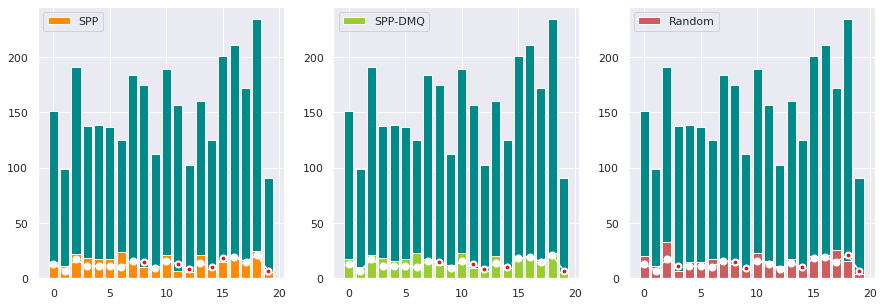

In [7]:
S_s, objectives_s = subm.greedygains_submod(None, X, mixw, k_budget)
S_sq, objectives_sq = subm.greedyIMquota_submod(None, X, mixw, Memvec, quo, k_budget)
S_r = np.random.choice(n_samples, k_budget)
objective_sr = subm.submodgains(X, np.sum(X[S_r,:], axis=0), 0, None, mixw)

print("Objective without quota", objectives_s[-1], "\n", S_s)
print("Objective with quota", objectives_sq[-1], "\n", S_sq)
print("Objective of random selection", objective_sr, "\n", S_r)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_s, "darkorange", "SPP")
plt.subplot(1,3,2)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_sq, "yellowgreen", "SPP-DMQ")
plt.subplot(1,3,3)
plottingtools.vizbalance_MQ(np.arange(n_samples), Memvec, "darkcyan", quo, S_r, "indianred", "Random")

---

<p style="background-color:#ccff66">
Constrained Submodular Max with Feature Quota
</p>

In [ ]:
#%% Greedy for FQ

"""
Work in progress
"""

def greedyFquota_submod(V, X, mixw, Memvec, quo, k, verbose=False):
    """ For the feature quota.
        Memvec is a real-valued n x p membership "extent" matrix.
        quo is a real-valued p x 1 vector.
        Output a subset that satisfies the quotas.
    """
    return None
    
    [n,m] = X.shape
    p = Memvec.shape[1]
    
    if V is None:
        V = np.arange(n)
    
    for grp in range(p):
        if np.sum(Memvec[:,grp]) < quo[grp]:
            print("Not enough features in group {}, infeasible problem.".format(grp))
            return None, None
        
    objs = np.empty(k+1)
    
    A = np.empty(0, int)
    modA = np.sum(X[A,:], axis=0)
    ff = 0 # assume normalized for now
    objs[0] = ff
    
    """ Quota-filling stage """
    
    Memsat = np.copy(Memvec) # look at this like a "saturation potential"
    sat = np.copy(quo) # to keep track of what is satisfied
    
    # ignore groups with zero quota
    for grp in range(p):
        if quo[grp] < 1:
            Memsat[:,grp] = 0
            sat[grp] = 0
    
    Vsat = V[np.sum(Memsat[V,:], axis=1)>0] # only for use in the quota-filling stage
    ii = 0

    while (sat>0).any():
        
        maxgain = -100
        try:
            greedyv = np.random.choice(Vsat)
        except:
            if len(Vsat) == 0:
                print("Vsat is exhausted without satisfying all quotas??", Vsat)
                print("sat = ", sat)
        
        for vidx in range(len(Vsat)):
            gain = subm.submodgains(X, modA, ff, Vsat[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = Vsat[vidx]
        
        # add element to A, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        ff += maxgain
        objs[ii+1] = ff
        
        grps = np.argwhere(Memsat[greedyv]).flatten() # note that grp can be a list
        
        if verbose:
            print("selected element", greedyv)
            print("lies in unsatisfied groups", grps)
            #print("new A", A)
        
        # remove from V and Vsat
        V = V[V!=greedyv]
        Memsat[greedyv,:] = 0
        Vsat = Vsat[Vsat!=greedyv]
        
        # also remove from Vsat those who have no uniqueness to offer
        for grp in grps:
            if np.sum(Memvec[A,grp]) >= quo[grp]:
                sat[grp] = 0
                Memsat[:,grp] = 0
                if verbose:
                    print("\n Quota for group {} satisfied by set {} \n".format(
                            grp, A[Memvec[A,grp].flatten().astype(bool)]
                        ))
                    print("Deleting {}".format(
                            Vsat[np.sum(Memsat[Vsat,:], axis=1)==0]
                        ))
                Vsat = Vsat[np.sum(Memsat[Vsat,:], axis=1)>0]
        
        ii += 1
        
    if verbose:
        print("Quotas filled.")
        print("quotas : ", quo)
        print("Representatives : ", [np.sum(Memvec[A,jj]) for jj in range(p)])
    
    """ Regular greedy stage """
    
    while ii < k:
        
        maxgain = -100
        greedyv = np.random.choice(V)
        
        for vidx in range(len(V)):
            gain = subm.submodgains(X, modA, ff, V[vidx], mixw)
            if gain > maxgain:
                maxgain = gain
                greedyv = V[vidx]
        
        # add element to A, remove from V, update gains
        A = np.append(A, greedyv)
        modA += X[greedyv,:]
        V = V[V!=greedyv]
        ff += maxgain
        objs[ii+1] = ff
        
        if verbose:
            print("selected element", greedyv)
            print("lies in group", np.argwhere(Memvec[greedyv]))
            #print("new A", A)
        
        ii += 1
    
    return A, objs


- - - 

## Greedy v/s WeightedGreedy